# EMNIST

In [1]:
# Import dependencies
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision
import seaborn as sns
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch
from tqdm import tqdm
from datetime import datetime
import yaml
import h5py
from copy import deepcopy

/home/nislah/.vmgr_repo/dev-2021-02-py38/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Seed for reproducibility
torch.manual_seed(42)
print(device)

cuda


In [3]:
# Create the working directory from timestamp and model name
model_name = 'cvae_emnist' # invertible network
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
workingDir = f'results/{model_name}_{timestamp}'
os.mkdir(workingDir)

In [4]:
# Create configuration file
configDict = {
'workingDir': workingDir,
'timestamp' : timestamp,
#'dataset': 'MNIST', # Define working dataset
'model': model_name, # Model
'lr': 1e-3, # Learning rate
'batch_size': 64,
'n_epochs': 50,
'kernel_size': 4, # kernel size
"init_channels": 8, # initial number of filters
"image_channels": 1, # 1 for MNIST (grayscale)
"latent_dim": 4 # latent dimension for sampling
}

with open(f'{workingDir}/config.yaml', 'w') as file:
    documents = yaml.dump(configDict, file)

In [5]:
# Load configuration file
with open(f'{workingDir}/config.yaml','r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
params

{'batch_size': 64,
 'image_channels': 1,
 'init_channels': 8,
 'kernel_size': 4,
 'latent_dim': 4,
 'lr': 0.001,
 'model': 'cvae_emnist',
 'n_epochs': 50,
 'timestamp': '20220117_124800',
 'workingDir': 'results/cvae_emnist_20220117_124800'}

In [6]:
# Import parameters and construct model and optimizers
lr=params['lr']
batch_size=params['batch_size']
n_epochs=params['n_epochs']
kernel_size=params['kernel_size'] # kernel size
init_channels=params['init_channels'] # initial number of filters
image_channels=params['image_channels'] # 1 for MNIST (grayscale)
latent_dim=params['latent_dim'] # latent dimension for sampling
TRAIN_CVAE = True
TRAIN_VAE = False
PLOT_VAE = False
TRAIN_READOUT = False
TRAIN_READIN = False

In [7]:
# Define datasets
# Prepare the data loader for the MNIST dataset:
transform = transforms.Compose([transforms.ToTensor()])#,  transforms.Resize((32,32))]) # Dataset transform #  lambda x: (x>0.5).float(),
dataset = datasets.EMNIST(root='/share/datasets', download=False, split='letters', train=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [100000, 24800])
test_set = datasets.EMNIST(root='/share/datasets', download=False, split='letters', train=False, transform=transform)
# dataset = datasets.MNIST(root='/share/datasets', download=False, train=True, transform=transform)
# train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=12, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=12, shuffle=False)

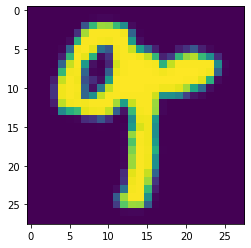

In [8]:
plt.imshow(next(iter(train_loader))[0][0].permute(1,2,0))
x,t=next(iter(train_loader))
x0,t0=x[0],t[0]

In [9]:
# !tensorboard --logdir=./tb_logs

In [17]:
from models.cvae import *
tb_logger = TensorBoardLogger('tb_logs', name=model_name)
enc_layers = [28*28, 512]
dec_layers = [512, 28*28]
model = EMNIST_CVAE(latent_dim, enc_layers, dec_layers, n_classes=26, conditional=True).to(device)
print(model)
trainer = pl.Trainer(
                     gpus=1,
                     logger=tb_logger,
                     max_epochs=100,
#                      callbacks=[
#                          pl.callbacks.early_stopping.EarlyStopping(
#                              monitor='Val/Loss',
#                              mode='min',
#                              patience=5
#                          )
#                      ],
                    auto_lr_find=True)
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params
-------------------------------------------
0 | encoder | EMNIST_Encoder | 419 K 
1 | decoder | EMNIST_Decoder | 418 K 
-------------------------------------------
837 K     Trainable params
0         Non-trainable params
837 K     Total params
3.350     Total estimated model params size (MB)


EMNIST_CVAE(
  (encoder): EMNIST_Encoder(
    (MLP): Sequential(
      (L0): Linear(in_features=810, out_features=512, bias=True)
      (A0): ReLU()
    )
    (fc_mu): Linear(in_features=512, out_features=4, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=4, bias=True)
  )
  (decoder): EMNIST_Decoder(
    (MLP): Sequential(
      (L0): Linear(in_features=30, out_features=512, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=512, out_features=784, bias=True)
      (sigmoid): Sigmoid()
    )
  )
)
Epoch 0:  80%|████████████████████████████████████████████████            | 1563/1951 [00:08<00:02, 184.86it/s, loss=193, v_num=33]
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|████████████████████████████████████████████████            | 1563/1951 [00:08<00:02, 181.96it/s, loss=186, v_num=33]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|████████████████████████████████████████████████            | 1563/1951 [00:08<00:02, 182.14it/s, loss=181, v_num=33]
Validating: 

# Train CVAE

In [11]:
if TRAIN_VAE:

    model = MLPVAE(
    latent_dim = latent_dim # latent dimension for sampling
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction='sum')

    model = model.to(device)
    n_train = len(trainloader)
    n_val = len(testloader)
    for i in tqdm(range(n_epochs)):
        running_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            rec, mu, logvar = model(images)
            loss = loss_function(rec, images, mu, logvar, criterion)
            running_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        for _, (images, labels) in enumerate(testloader):
            with torch.no_grad():
                images = images.to(device)
                rec, mu, logvar = model(images)
                loss =loss_function(rec, images, mu, logvar, criterion)
                val_loss += loss
        print(f"Epoch: {i+1} \t Train Loss: {running_loss/n_train:.2f} \t Val Loss: {val_loss/n_val:.2f}")

        torch.save(model, 'results/MLP_VAE2.pt')
else:
    model = torch.load('results/MLP_VAE2.pt').to(device)
    model.eval()
    print(model)

MLPVAE(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc1_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc1_logvar): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1024, bias=True)
  )
)


# Train VAE

In [12]:
from models.vae import MLPVAE

def loss_function(rec, x, mu, logvar, criterion):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    rec_error = criterion(rec, x)
    return KLD + rec_error

if TRAIN_VAE:

    model = MLPVAE(
    latent_dim = latent_dim # latent dimension for sampling
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction='sum')

    model = model.to(device)
    n_train = len(trainloader)
    n_val = len(testloader)
    for i in tqdm(range(n_epochs)):
        running_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            rec, mu, logvar = model(images)
            loss = loss_function(rec, images, mu, logvar, criterion)
            running_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        for _, (images, labels) in enumerate(testloader):
            with torch.no_grad():
                images = images.to(device)
                rec, mu, logvar = model(images)
                loss =loss_function(rec, images, mu, logvar, criterion)
                val_loss += loss
        print(f"Epoch: {i+1} \t Train Loss: {running_loss/n_train:.2f} \t Val Loss: {val_loss/n_val:.2f}")

        torch.save(model, 'results/MLP_VAE2.pt')
else:
    model = torch.load('results/MLP_VAE2.pt').to(device)
    model.eval()
    print(model)

MLPVAE(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc1_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc1_logvar): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1024, bias=True)
  )
)


In [13]:
from utils.vae_utils import *

if PLOT_VAE:
    latent_space_viz(model, trainloader, 2000)
    latent_space_viz(model, testloader, 2000)
    plot_reconstruction(model, trainloader)
    plot_reconstruction(model, testloader)

# Readout Training

In [14]:
from models.readout import *
    
if TRAIN_READOUT:
    readout = Readout(latent_dim=latent_dim).to(device)
    readout_opt = optim.Adam(readout.parameters(), lr=1e-3)
    n_readout_epochs = 20
    criterion = nn.CrossEntropyLoss(reduction='sum')
    for i in tqdm(range(n_readout_epochs)):
        train_loss, val_loss, val_acc = 0, 0, 0
        for _, (images, labels) in enumerate(trainloader):
            loss, _ = loss_readout(readout, model, images, labels, criterion)
            readout_opt.zero_grad()
            loss.backward()
            readout_opt.step()
            train_loss += loss/len(trainloader)

        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            loss, pred = loss_readout(readout, model, images, labels, criterion)
            val_loss += loss/len(testloader)
            val_acc += (torch.argmax(pred,1)==labels).float().sum()
        
        val_acc = val_acc/(batch_size*len(testloader))
        print(f"Epoch:{i+1} \t Train Loss:{train_loss:.3f} \t Val Loss:{val_loss:.3f} \t Val Acc:{val_acc:.3f}")
        torch.save(readout, 'results/readout_mlpvae3.pt')

else:
    readout = torch.load('results/readout_mlpvae3.pt').to(device)

In [15]:
batch_size=32
transform = transforms.Compose([transforms.ToTensor(),  transforms.Resize((32,32))]) # Dataset transform #  lambda x: (x>0.5).float(),
testset = datasets.MNIST(root='/share/datasets', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
train_loss, val_loss, val_acc = 0, 0, 0
for _, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)
    loss, pred = loss_readout(readout, model, images, labels)
    val_loss += loss/len(testloader)
    val_acc += (torch.argmax(pred,1)==labels).float().sum()
val_acc = val_acc/(batch_size*len(testloader))
print(f"Val Loss:{val_loss:.3f} \t Val Acc:{val_acc:.3f}")

Val Loss:0.183 	 Val Acc:0.941


# Expectation clamp

## Ambiguous Data Generator

In [16]:
from models.ambiguous_generator import MNISTGenerator, Encoder, Decoder
from utils.data_utils import *

tform = transforms.Compose([transforms.ToTensor()]) # Dataset transform # lambda x: (x>0.5).float()
evalset = datasets.MNIST(root='/share/datasets', download=True, train=False, transform=tform)
ambi_batch_size = 2000
ambiguousLoader = DataLoader(evalset, batch_size=ambi_batch_size, shuffle=True)
tf = transforms.Compose([transforms.Resize((32,32))]) # Dataset transform # lambda x: (x>0.5).float(), 
encoder=torch.load("/home/nislah/vmgr/NSERC/CVAE_encoder.pt").to(device)
decoder=torch.load("/home/nislah/vmgr/NSERC/CVAE_decoder.pt").to(device)
MNISTgen = MNISTGenerator(encoder, decoder, ambiguousLoader, device=device)
low,high = 0.5,0.5
ambiguity = map_true_ambiguity(model, readout, MNISTgen, pure_pairs, ambi_batch_size, tf)

SyntaxError: invalid syntax (data_utils.py, line 9)

In [ ]:
from models.topdown import *
from utils.topdown_utils import *

readin_batch_size = 2
trainloader = DataLoader(trainset, batch_size=readin_batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=readin_batch_size, shuffle=False)
ambiguousLoader = DataLoader(evalset, batch_size=readin_batch_size, shuffle=True)
MNISTgen = MNISTGenerator(encoder, decoder, ambiguousLoader, device=device)
centroids = find_centroids(model, trainloader, latent_dim)
crit = nn.MSELoss(reduction='sum')

if TRAIN_READIN:
    readin = MLPReadinLatentContext(n_latent=latent_dim).to(device) # MLPReadinLatent(n_latent=latent_dim).to(device)
    optimizer = torch.optim.Adam(readin.parameters(), lr=1e-2)
    for param in readout.parameters():
        param.requires_grad = False # Freeze all weights
    for param in model.parameters():
        param.requires_grad = False
        
    UPDATE_EVERY = 32
    n_epochs=15
    losses = {'train':[], 'val':[]}
    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        n_train = 0
        running_loss = 0
        c = 0
        for i, (x_star, t) in enumerate(trainloader):
            x_star,t = x_star.to(device), t.to(device)
            loss, mu, mu_star, mu_prime, mu_pp, mu_ss = loss_readin_latent_context(x_star, t, model, readin, readout, MNISTgen, 
                                                                                 centroids, crit, tf, ambiguity)
            if loss > 0:
                c += 1
                n_train += readin_batch_size
                running_loss += loss
                train_loss += loss
                if (c+1) % UPDATE_EVERY == 0:
                    optimizer.zero_grad()
                    running_loss.backward()
                    optimizer.step()
                    running_loss = 0

        val_loss = 0
        bench_val_1, bench_val_2 = 0,0
        val_acc_1, val_acc_2, val_acc_3 = 0,0,0
        n_val = 0
        readin.eval()
        for i, (x_star, t) in enumerate(testloader):
            x_star,t = x_star.to(device), t.to(device)
            loss, mu, mu_star, mu_prime, mu_pp, mu_ss = loss_readin_latent_context(x_star, t, model, readin, readout, MNISTgen, 
                                                                                 centroids, crit, tf, ambiguity)
            if loss > 0:
                n_val+= readin_batch_size
                val_loss += loss
                benchmark_1, exp_1, benchmark_2, exp_2,exp_3 = accuracy(readout, t, mu, mu_star, mu_prime, mu_pp, mu_ss)
                bench_val_1 += benchmark_1
                bench_val_2 += benchmark_2
                val_acc_1 += exp_1
                val_acc_2 += exp_2
                val_acc_3 += exp_3
                
        losses['train'].append(train_loss.cpu().detach().numpy()/n_train)
        losses['val'].append(val_loss.cpu().detach().numpy()/n_val)

        print(f"Epoch:{epoch+1} \t Train Loss:{train_loss/n_train:.3f} \t Val Loss:{val_loss/n_val:.3f} \
              \t Val Acc 1:{val_acc_1/n_val:.3f} \t Val Acc 2:{val_acc_2/n_val:.3f} \
              \t Val Acc 3:{val_acc_3/n_val:.3f} \t Bench Val 1:{bench_val_1/n_val:.3f} \t Bench Val 2:{bench_val_2/n_val:.3f}")
        
        torch.save(readin, 'results/vae_mlp_readinlatent4.pt')
        np.save('results/train_loss.npy', np.array(losses['train']))
        np.save('results/val_loss.npy', np.array(losses['val']))

else:
    readin = torch.load('results/vae_mlp_readinlatent4.pt')
    losses = {'train': np.load('results/train_loss.npy'), 'val': np.load('results/val_loss.npy')}

In [ ]:
plot_training_curve(losses['train'], losses['val'])
val_acc_1, val_acc_2, val_acc_3, bench_val_1, bench_val_2 = testset_accuracy(testloader, readin_batch_size, model, readin, readout, MNISTgen, centroids, crit, tf, ambiguity) # todo: fix
plot_accuracy(val_acc_1, bench_val_1, val_acc_2, bench_val_2)

In [ ]:
# e_weights = np.arange(0,1.01,0.2)
# v1,v2,b1,b2 = vary_expectation(e_weights, trainloader, readin_batch_size, model, readin, readout, MNISTgen, centroids, crit, tf, ambiguity)
# plot_expectation_weight(v1,v2,b1,b2)

In [ ]:
# e_weight=0.5
# mu_amb, mu_primes_mid, mu_primes, mu_stars, targets = topdown_inference(trainloader, latent_dim, model, readin, readout, MNISTgen, centroids, crit, tf, ambiguity, samples=int(50e3),e_weight=e_weight)
# latents = viz_topdown_latents(mu_amb, mu_primes_mid, mu_primes, mu_stars, targets)

In [ ]:
# sim1, sim2,sim3,sim4,td1,td2,bot1,bot2 = apical_basal_correlation(trainloader, latent_dim, model, readin, readout, MNISTgen, centroids, crit, tf, ambiguity)

In [ ]:
# barplot_correlation(sim1,sim2,sim3,sim4)

In [ ]:
# activation_histogram(td1,td2,bot1,bot2)

In [ ]:
# mask = bot2 > 0 # active in unambiguous
# td1,td2,bot1,bot2 = td1.flatten(),td2.flatten(),bot1.flatten(),bot2.flatten()
# apical_basal_scatterplot(td1, bot1, mask) # ambiguous both
# apical_basal_scatterplot(td1, bot2, mask) # ambiguous apical, unamibguous basal
# apical_basal_scatterplot((1+td1)*bot1, bot2, mask) # post-combination, and unambiguous basal

In [ ]:
# exp = np.arange(0,1.01,0.1)
# amb = np.arange(0,0.51,0.1)
# hmap, hmap_counter = heatmap(amb, exp, testloader, readin_batch_size, model, readin, readout, MNISTgen, centroids, crit, tf, ambiguity)

In [ ]:
# hmap=np.load("results/heatmap.npy")
# hmap_counter=np.load("results/heatmap_counterfactual.npy")
# plot_heatmap(hmap, title="Aligned Expectation", savefile="results/heatmap.pdf")
# plot_heatmap(hmap_counter, title="Misaligned Expectation", savefile="results/heatmap_counterfactual.pdf")